In [63]:
import pandas as pd

In [64]:
data = pd.read_parquet("pump_station_data.parquet")
df = pd.DataFrame(data['2023-02-14 10:00:00':'2023-02-16 02:00:00'])
df = df['2023-02-14 11:20:00':'2023-02-14 13:20:00'].resample("10s").mean() # smaller amount of samples to get residuals
#df = pd.DataFrame(data['2023-02-14 10:00:00':'2023-02-14 14:00:00'])
COLS = df.columns
df.head()

,height,outflow,pump1_rpm,pump1_power,pump4_rpm,pump4_power
time,,,,,,
2023-02-14 11:20:00+00:00,157.9,411.7,0.0,0.0,969.0,42.010
2023-02-14 11:20:10+00:00,157.7,421.6,0.0,0.0,961.3,41.595
2023-02-14 11:20:20+00:00,158.0,405.0,0.0,0.0,960.0,41.600
2023-02-14 11:20:30+00:00,158.0,406.1,0.0,0.0,966.0,41.695
2023-02-14 11:20:40+00:00,158.0,429.2,0.0,0.0,990.0,43.833


In [65]:
df = df.reset_index(drop=True)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

In [66]:
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler

In [67]:
import matplotlib.pyplot as plt
from sysidentpy.metrics import mean_squared_error
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.general_estimators import NARX
from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)

In [68]:
train_split_size = 0.7

train_df = df_scaled[:int(train_split_size*len(df_scaled))]
test_df = df_scaled[int(train_split_size*len(df_scaled)):]

FEATURES = ['pump1_rpm','pump4_rpm']
TARGET = 'outflow'

x_train, y_train = train_df[FEATURES].values, train_df[TARGET].values
x_test, y_test= test_df[FEATURES].values, test_df[TARGET].values

In [69]:
from sysidentpy.general_estimators import NARX

basis_function = Fourier(degree=2)

catboost_narx = NARX(
    base_estimator=CatBoostRegressor(iterations=600, learning_rate=0.3, depth=8),
    xlag=[[2], [2]],
    ylag=2,
    basis_function=basis_function,
    model_type="NARMAX",
    fit_params={"verbose": False},
)

catboost_narx.fit(X=x_train, y=y_train.reshape(-1,1))

In [71]:


yhat = catboost_narx.predict(X=x_test, y=y_test.reshape(-1,1), steps_ahead=1)
print("RRSE: ", root_relative_squared_error(y_test.reshape(-1,1), yhat))
print("MSE: ", mean_squared_error(y_test, yhat))



RRSE:  0.47266842177173973
MSE:  0.9658258357658579


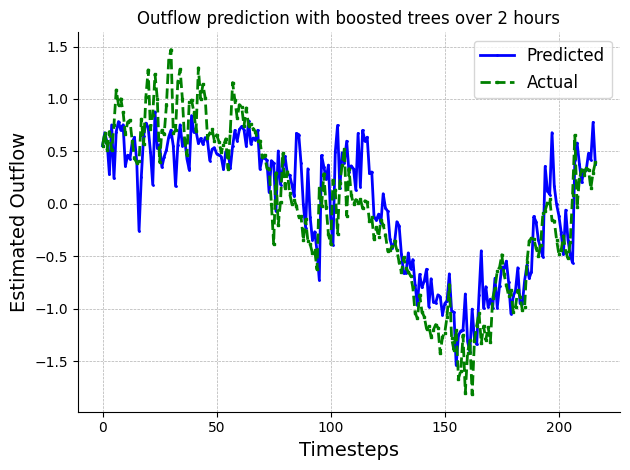

In [72]:
import matplotlib.pyplot as plt 
plt.plot(yhat[:500], color='blue', linestyle='-', linewidth=2, marker='o', markersize=1, label='Predicted')
plt.plot(y_test[:500], color='green', linestyle='--', linewidth=2, marker='s', markersize=1.5, label='Actual')
plt.xlabel('Timesteps', fontsize=14)
plt.ylabel('Estimated Outflow', fontsize=14)
plt.title('Outflow prediction with boosted trees over 2 hours')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding a legend
plt.legend(fontsize=12)

# Adjusting the margins and layout
plt.tight_layout()

# Show the plot
plt.show()

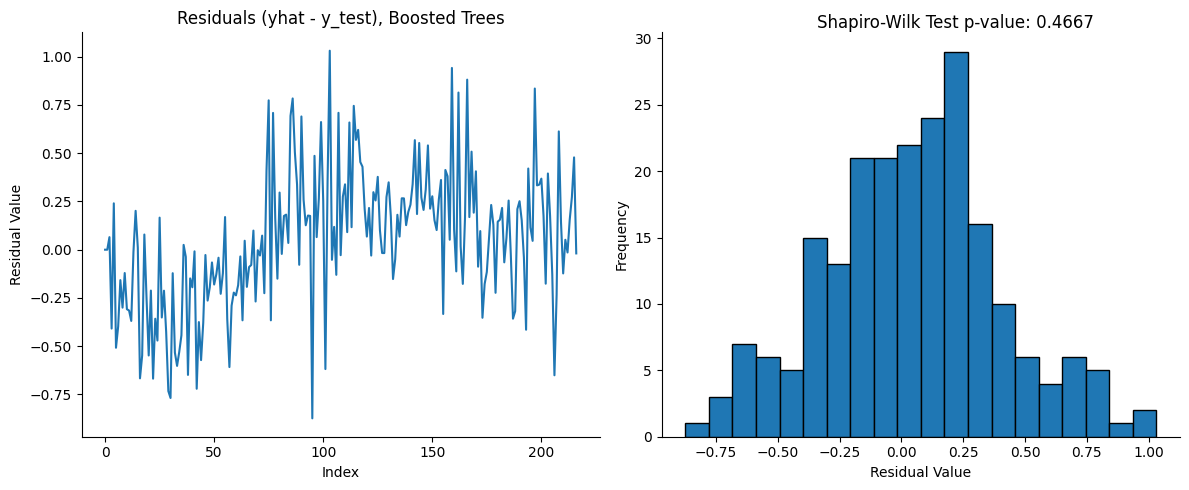

Shapiro-Wilk Test result:
Statistic: 0.9935, p-value: 0.4667


In [62]:
from scipy.stats import shapiro


residuals = yhat.squeeze() - y_test

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Plot of residuals
axs[0].plot(residuals)
axs[0].set_title('Residuals (yhat - y_test), Boosted Trees')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Residual Value')

# Second subplot: Histogram of residuals
axs[1].hist(residuals, bins=20, edgecolor='black')
axs[1].set_xlabel('Residual Value')
axs[1].set_ylabel('Frequency')

# Perform Shapiro-Wilk Test for normality
stat, p = shapiro(residuals)
axs[1].annotate(f'Shapiro-Wilk Test p-value: {p:.4f}', xy=(0.3, 1.01), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

# Print Shapiro-Wilk Test result
print("Shapiro-Wilk Test result:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")

In [ ]:
alpha = 0.05  # significance level
if p > alpha:
    print("The Shapiro-Wilk test is successful: the data follows a normal distribution.")
else:
    print("The Shapiro-Wilk test is unsuccessful: the data does not follow a normal distribution.")
    